In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Liberaries

In [2]:
!source /content/drive/MyDrive/colab_env/bin/activate

In [3]:
import os
import sys
sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
import netCDF4 as gpd
import ee
import wxee
import geemap
import rioxarray
import rasterio
import pickle
import geopandas as gpd
import pyproj

sys.path.append('/content/drive/MyDrive/WaterBalance_new/')

from qdwb.primary_surface_flow.primary_surface_flow import *
from qdwb.primary_surface_flow.asset import *
from qdwb.coordinate.extract import *

## Authorize in Google Earth Engine

In [4]:
service_account = 'test-175@ee-mohammadnejadmehdi77.iam.gserviceaccount.com'

credentials = ee.ServiceAccountCredentials(
    email=service_account, 
    key_file='/content/drive/MyDrive/private-key.json'
)

ee.Initialize(credentials)

# Directory and extend of basin

In [5]:
PATH_DATA = "/content/drive/MyDrive/WaterBalance_new/assets/"

# mashhad
LAT_MIN = 35.80
LAT_MAX = 37.11
LON_MIN = 58.31
LON_MAX = 60.14

# USA
# LAT_MIN = 43.30
# LAT_MAX = 44.60
# LON_MIN = -109.40
# LON_MAX = -107.40


# Functions

In [6]:
def mask_nc_file(
    nc,
    variable,
    lat_min,
    lat_max,
    lon_min,
    lon_max
):
    with xr.open_dataset(nc) as xr_nc:
        result = xr_nc.sel(
            lat = slice(lat_max, lat_min),
            lon = slice(lon_min, lon_max),
        )
    return result

## Load Data precipitation

In [7]:
# mm d-1 - precipitation
P = mask_nc_file(
    nc = PATH_DATA + "nc/P_2022031.nc",
    variable = "precipitation",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
 
# mashhad = gpd.read_file('/mnt/e/Term2/WERI/test/Export_Output.shp')

usa = gpd.read_file(PATH_DATA + "shape/usa.shp")
mashhad = gpd.read_file(PATH_DATA + "shape/mahdoode_mashhad.shp")


## Load Data Curve Number

In [9]:


# Map = geemap.Map()
# Map.add_basemap('HYBRID')


shape = ee.Geometry.Rectangle([LON_MAX,LAT_MIN,LON_MIN,LAT_MAX])


# Import the GCN250 Images and rename bands
# GCN250_Average =  ee.Image("users/jaafarhadi/GCN250/GCN250Average").select('b1').rename('average')
CN_Wyoming =  ee.Image("users/jaafarhadi/GCN250/GCN250Dry").select('b1').rename('dry')
# GCN250_Wet = ee.Image("users/jaafarhadi/GCN250/GCN250Wet").select('b1').rename('wet')


CN_Wyoming = CN_Wyoming.clip(shape)
 
# Map.centerObject(shape, 9)
# Map.addLayer(CN_Wyoming, {'min':40, 'max':75, 'palette': ['Red','SandyBrown','Yellow','LimeGreen', 'Blue','DarkBlue']}, 'CN_Wyoming')
# Map

### convert to xarray

In [10]:
crs = 4326
CN_Wyoming = CN_Wyoming.set("system:time_start", ee.Date("2015"))
arr = CN_Wyoming.wx.to_xarray(scale=250, crs=f'EPSG:{crs}')
arr

Downloading:   0%|          | 0.00/71.0k [00:00<?, ?iB/s]

<xarray.Dataset>
Dimensions:  (time: 1, y: 586, x: 816)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01
  * y        (y) float64 37.11 37.11 37.11 37.11 37.1 ... 35.81 35.8 35.8 35.8
  * x        (x) float64 58.31 58.31 58.32 58.32 ... 60.13 60.14 60.14 60.14
Data variables:
    dry      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    transform:               (0.002245788210298804, 0.0, 58.309645092198146, ...
    crs:                     +init=epsg:4326
    res:                     (0.002245788210298804, 0.002245788210298804)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

### change crs precipitation data

In [11]:
data = P
data = data.rename({'lon': 'x','lat': 'y'})

if crs == 4326:
  data_pre = data.rio.write_crs("epsg:4326", inplace=True)
else:
  # Define the source and target CRS
  source_crs = pyproj.CRS('EPSG:4326')
  target_crs = pyproj.CRS(f'EPSG:{crs}')

  # Create a coordinate transformer
  transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)

  # Reproject the data to the target CRS
  data = data.rio.write_crs("epsg:4326", inplace=True)
  reprojected_data = data.rio.reproject(target_crs, transformer=transformer)
  data_pre = reprojected_data

data_pre

<xarray.Dataset>
Dimensions:        (x: 18, y: 13, time: 1)
Coordinates:
  * x              (x) float32 58.35 58.45 58.55 58.65 ... 59.85 59.95 60.05
  * y              (y) float32 37.05 36.95 36.85 36.75 ... 36.05 35.95 35.85
  * time           (time) datetime64[ns] 2022-01-31
    spatial_ref    int64 0
Data variables:
    precipitation  (time, y, x) float32 ...
Attributes:
    history:          Created on 2022-02-05 07:15
    input_data_hash:  27d78e1ad0241438dcb7b796dee6d7c1393f1b4522680997748376e...

### reroject CN array accoring to precipitation array

In [13]:


xds_repr_match = arr.rio.reproject_match(data_pre, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match


<xarray.Dataset>
Dimensions:      (x: 18, y: 13, time: 1)
Coordinates:
  * x            (x) float32 58.35 58.45 58.55 58.65 ... 59.75 59.85 59.95 60.05
  * y            (y) float32 37.05 36.95 36.85 36.75 ... 36.15 36.05 35.95 35.85
  * time         (time) datetime64[ns] 2015-01-01
    spatial_ref  int64 0
Data variables:
    dry          (time, y, x) float64 75.0 57.0 57.0 57.0 ... 57.0 59.0 75.0
Attributes:
    transform:               (0.002245788210298804, 0.0, 58.309645092198146, ...
    crs:                     +init=epsg:4326
    res:                     (0.002245788210298804, 0.002245788210298804)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

## plot reprojected CN array

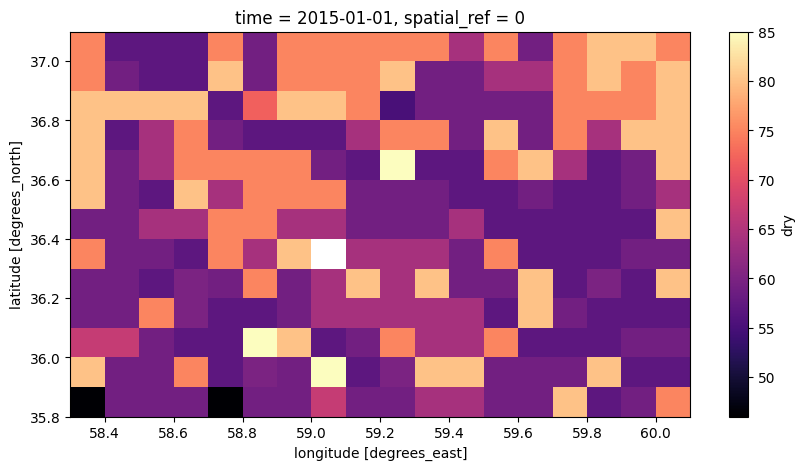

In [14]:
xds_repr_match.dry.plot(figsize=(10, 5), cmap="magma")

# estimate runoff and underground runoff by scs method

## with steady antecedent_precipitation

In [16]:
cn =list(xds_repr_match.dry.values.flatten())
pre =list(data_pre.precipitation.values.flatten())


number_of_x = len(list(data_pre.x.values.flatten()))
number_of_y = len(list(data_pre.y.values.flatten()))



run_off = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = float(j),
    rsa = True,
    antecedent_precipitation = 100,
    is_growing_season = True
)[0]
for i, j in zip(pre,cn)])


underground_runoff = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = float(j),
    rsa = True,
    antecedent_precipitation = 100,
    is_growing_season = True
)[1]
for i, j in zip(pre,cn)])


precipitation_array = np.array(pre)

run_off_array = run_off.reshape(1,number_of_y,number_of_x)
underground_runoff_array = underground_runoff.reshape(1,number_of_y,number_of_x)
precipitation_array = precipitation_array.reshape(1,number_of_y,number_of_x)

ds_array = xds_repr_match.assign(run_off=(['time', 'y', 'x'], run_off_array))
ds_array_1 = ds_array.assign(underground_runoff=(['time', 'y', 'x'], underground_runoff_array))
ds_array_2 = ds_array_1.assign(precipitation=(['time', 'y', 'x'], precipitation_array))
ds_array_2


<xarray.Dataset>
Dimensions:             (x: 18, y: 13, time: 1)
Coordinates:
  * x                   (x) float32 58.35 58.45 58.55 ... 59.85 59.95 60.05
  * y                   (y) float32 37.05 36.95 36.85 ... 36.05 35.95 35.85
  * time                (time) datetime64[ns] 2015-01-01
    spatial_ref         int64 0
Data variables:
    dry                 (time, y, x) float64 75.0 57.0 57.0 ... 57.0 59.0 75.0
    run_off             (time, y, x) float64 1.841 4.166 4.166 ... 3.837 1.841
    underground_runoff  (time, y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    precipitation       (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    transform:               (0.002245788210298804, 0.0, 58.309645092198146, ...
    crs:                     +init=epsg:4326
    res:                     (0.002245788210298804, 0.002245788210298804)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

## import soil moisture data from NASA and ERA5

In [18]:
# Map = geemap.Map()
# Map.add_basemap('HYBRID')

soilmoisture = ee.ImageCollection('NASA_USDA/HSL/SMAP10KM_soil_moisture').filter(ee.Filter.date('2022-01-31T00:00:00', '2022-02-01T00:00:00')).select('ssm').mean().clip(shape)

sub_soilmoisture = ee.ImageCollection('NASA_USDA/HSL/SMAP10KM_soil_moisture').filter(ee.Filter.date('2022-01-31T00:00:00', '2022-02-01T00:00:00')).select('susm').mean().clip(shape)

soil_era_evap = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filter(ee.Filter.date('2022-01-31', '2022-02-01')).select('volumetric_soil_water_layer_1').mean().clip(shape)

# Map.centerObject(shape, 9)
# Map.addLayer(soilmoisture, {'min':0, 'max':28, 'palette': ['0300ff', '418504', 'efff07', 'efff07', 'ff0303']}, 'soilmoisture')
# Map

### convert soil moisture to xarray file

In [19]:

soilmoisture = soilmoisture.set("system:time_start", ee.Date("2022-01-31"))
sub_soilmoisture = sub_soilmoisture.set("system:time_start", ee.Date("2022-01-31"))
soil_era_evap_1 = soil_era_evap.set("system:time_start", ee.Date("2022-01-31"))

arr_soilmoisture = soilmoisture.wx.to_xarray(scale=10000, crs=f'EPSG:{crs}')
arr_sub_soilmoisture = sub_soilmoisture.wx.to_xarray(scale=10000, crs=f'EPSG:{crs}')
arr_soil_era_evap_1 = soil_era_evap_1.wx.to_xarray(scale=11132, crs=f'EPSG:{crs}')


Downloading:   0%|          | 0.00/1.86k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/1.88k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?iB/s]

### reproject soil moisture accoring to precipitation array

In [22]:
da_soilmoisture = arr_soilmoisture.rio.write_crs(f"epsg:{crs}", inplace=True)
da_sub_soilmoisture = arr_sub_soilmoisture.rio.write_crs(f"epsg:{crs}", inplace=True)
da_soil_era_evap_1 = arr_soil_era_evap_1.rio.write_crs(f"epsg:{crs}", inplace=True)

xds_repr_match__soilmoisture = da_soilmoisture.rio.reproject_match(ds_array_2, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match__sub_soilmoisture = da_sub_soilmoisture.rio.reproject_match(ds_array_2, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match__soil_era_evap_1 = da_soil_era_evap_1.rio.reproject_match(ds_array_2, resampling = rasterio.enums.Resampling.nearest)

# convert volumetric to milimeter
xds_repr_match__soil_era_evap_1 = xds_repr_match__soil_era_evap_1 * 70


### plot ERA5 reprojected

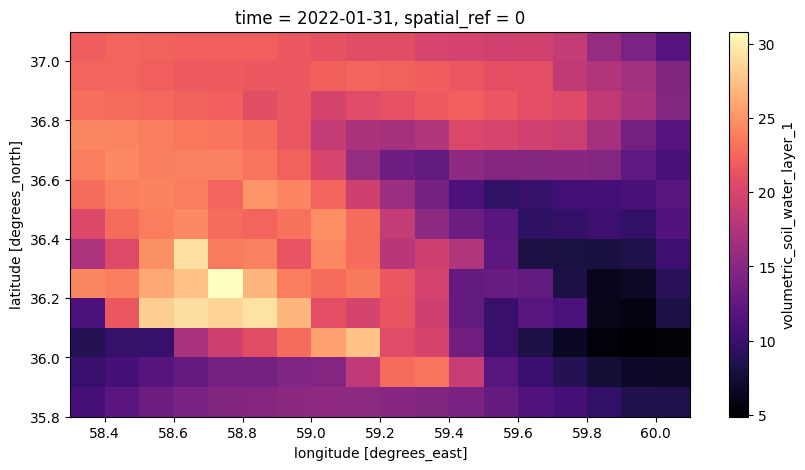

In [23]:
xds_repr_match__soil_era_evap_1.volumetric_soil_water_layer_1.plot(figsize=(10, 5), cmap="magma")

### plot NASA reprojected

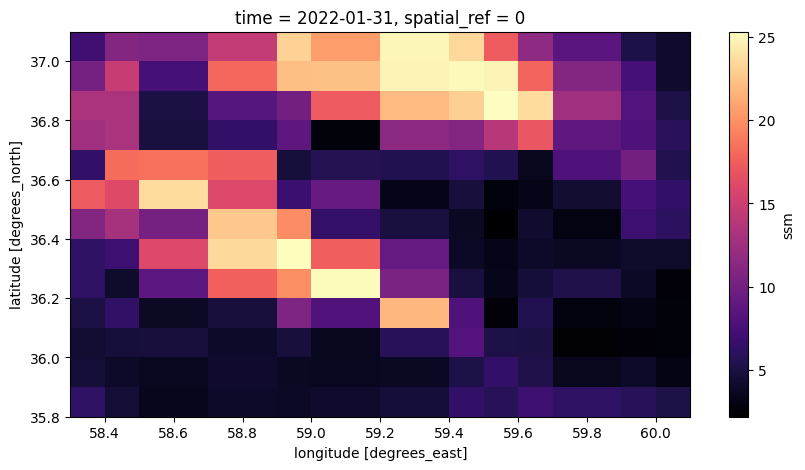

In [24]:
xds_repr_match__soilmoisture.ssm.plot(figsize=(10, 5), cmap="magma")

## with Variable antecedent_precipitation

In [25]:
cn = list(xds_repr_match.dry.values.flatten())
pre = list(data_pre.precipitation.values.flatten())
soil = list(xds_repr_match__soilmoisture.ssm.values.flatten())
sub_soil = list(xds_repr_match__sub_soilmoisture.susm.values.flatten())
soil_era = list(xds_repr_match__soil_era_evap_1.volumetric_soil_water_layer_1.values.flatten())


runoff_array = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = float(j),
    rsa = True,
    antecedent_precipitation = float(z),
    is_growing_season = True
)[0]
for i, j, z in zip(pre, cn, soil)])

underground_runoff_array = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = float(j),
    rsa = True,
    antecedent_precipitation = float(z),
    is_growing_season = True
)[1]
for i, j, z in zip(pre, cn, soil)])

cn_array = np.array(cn)
soil_array = np.array(soil)
sub_soil_array = np.array(sub_soil)
soil_era_array = np.array(soil_era)

cn_array = cn_array.reshape(1,number_of_y,number_of_x)
runoff_array = runoff_array.reshape(1,number_of_y,number_of_x)
underground_runoff_array = underground_runoff_array.reshape(1,number_of_y,number_of_x)
soil_array = soil_array.reshape(1,number_of_y,number_of_x)
sub_soil_array = sub_soil_array.reshape(1,number_of_y,number_of_x)
soil_era_array = soil_era_array.reshape(1,number_of_y,number_of_x)


ds_array = data_pre.assign(runoff=(['time', 'y', 'x'], runoff_array))
ds_array_1 = ds_array.assign(underground_runoff=(['time', 'y', 'x'], underground_runoff_array))
ds_array_2 = ds_array_1.assign(soilmoisture=(['time', 'y', 'x'], soil_array))
ds_array_3 = ds_array_2.assign(sub_soilmoisture=(['time', 'y', 'x'], sub_soil_array))
ds_array_3_1 = ds_array_3.assign(soil_era=(['time', 'y', 'x'], soil_era_array))
ds_array_3_2 = ds_array_3_1.assign(cn_dry=(['time', 'y', 'x'], cn_array))


ds_array_3_2



<xarray.Dataset>
Dimensions:             (x: 18, y: 13, time: 1)
Coordinates:
  * x                   (x) float32 58.35 58.45 58.55 ... 59.85 59.95 60.05
  * y                   (y) float32 37.05 36.95 36.85 ... 36.05 35.95 35.85
  * time                (time) datetime64[ns] 2022-01-31
    spatial_ref         int64 0
Data variables:
    precipitation       (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    runoff              (time, y, x) float64 10.08 22.81 22.81 ... 21.01 10.08
    underground_runoff  (time, y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    soilmoisture        (time, y, x) float32 7.012 10.95 10.65 ... 5.79 5.155
    sub_soilmoisture    (time, y, x) float32 21.26 38.02 35.37 ... 19.01 16.76
    soil_era            (time, y, x) float64 21.95 22.47 22.22 ... 8.47 8.413
    cn_dry              (time, y, x) float64 75.0 57.0 57.0 ... 57.0 59.0 75.0
Attributes:
    history:          Created on 2022-02-05 07:15
    input_data_hash:  27d78e1ad0241438dcb7b796dee6d7c1393f1b4522680997748376e...

## convert shape file's crs from 4326 to 3857

In [ ]:
# shp_dir = PATH_DATA + "shape/usa.shp"
# shp_dir = PATH_DATA + "shape/mahdoode_mashhad.shp"

# shapefile = gpd.read_file(shp_dir)

# change CRS to epsg 3857
# data_shp = shapefile.to_crs(epsg=3857)
# write shp file
# data_shp.to_file(PATH_DATA+'shape/file_out.shp')


## clip xarray file by shape file

In [ ]:
shp_dir = PATH_DATA + "/shape/mahdoode_mashhad.shp"
# shp_dir_reprojected = PATH_DATA + "shape/file_out.shp"
# shapefile_reprojected = gpd.read_file(shp_dir_reprojected)
shapefile = gpd.read_file(shp_dir)

precip_da = add_shape_coord_from_data_array(ds_array_3_1, shp_dir, "shapefile")
ds_array_4 = ds_array_3_1.where(precip_da.shapefile==0, other=np.nan)



with open('/content/drive/MyDrive/WaterBalance_new/notebook/ds_array_4_mahdoode_mashhad_4326.pkl', 'wb') as f:
    pickle.dump(ds_array_4, f)

ds_array_4


<xarray.Dataset>
Dimensions:             (time: 1, y: 13, x: 18)
Coordinates:
  * x                   (x) float32 58.35 58.45 58.55 ... 59.85 59.95 60.05
  * y                   (y) float32 37.05 36.95 36.85 ... 36.05 35.95 35.85
  * time                (time) datetime64[ns] 2022-01-31
    spatial_ref         int64 0
Data variables:
    precipitation       (time, y, x) float32 nan nan 0.0 0.0 ... nan nan nan nan
    runoff              (time, y, x) float64 nan nan 22.81 22.81 ... nan nan nan
    underground_runoff  (time, y, x) float64 nan nan 0.0 0.0 ... nan nan nan nan
    soilmoisture        (time, y, x) float32 nan nan 10.65 10.65 ... nan nan nan
    sub_soilmoisture    (time, y, x) float32 nan nan 35.37 35.37 ... nan nan nan
    soil_era            (time, y, x) float64 nan nan 22.22 22.03 ... nan nan nan
    shapefile           (y, x) float64 nan nan 0.0 0.0 0.0 ... nan nan nan nan
Attributes:
    history:          Created on 2022-02-05 07:15
    input_data_hash:  27d78e1ad0241438dcb7b796dee6d7c1393f1b4522680997748376e...

# save xarray as a pickle file

In [26]:
with open('/content/drive/MyDrive/WaterBalance_new/notebook/runoff_mahdoode_mashhad_4326_without_clip.pkl', 'wb') as f:
    pickle.dump(ds_array_3_2, f)

